# 🏪 Retail Demand Forecasting & Dynamic Replenishment
## AI-Powered Inventory Optimization for Retail Operations

This notebook demonstrates a production-ready forecasting system specifically designed for retail businesses.

**Key Features:**
- Multi-store, multi-SKU forecasting across 5 locations
- Retail-specific patterns (promotions, holidays, seasonality)
- 8 major retail categories with realistic behavior
- Real holiday calendar (Black Friday, Christmas, Back to School, etc.)
- Store location and type variations (Urban, Suburban, Mall, Outlet)
- Dynamic reorder point calculation with safety stock

**Learning Objectives:**
- Generate realistic retail sales data with multiple factors
- Train ML models for demand forecasting
- Calculate dynamic reorder recommendations
- Visualize forecasts and inventory decisions
- Launch interactive dashboard for real-time analysis

In [1]:
# %% Setup and Imports
import sys
sys.path.insert(0, '..')

# Import our modules
from src.retail_data_generator import RetailDataGenerator
from src.forecasting_agent import DemandForecastingAgent
from src.model_loader import ModelLoader
from src.dashboard import ForecastingDashboard

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 10)
%matplotlib inline

print(" All modules imported successfully!")
print(f" Pandas version: {pd.__version__}")
print(f" NumPy version: {np.__version__}")

 All modules imported successfully!
 Pandas version: 2.3.3
 NumPy version: 2.2.5


In [2]:
# %% Generate Realistic Retail Sales Data
# Generate 2 years of sales data for a retail chain:
# - 5 stores across different locations
# - 20 SKUs across 8 retail categories
# - Realistic patterns: seasonality, promotions, holidays

# Initialize retail data generator
generator = RetailDataGenerator(seed=42)

print(" Generating retail sales data...")
print("  Configuration: 2 years, 20 SKUs, 5 stores")
print("  This may take 2-3 minutes...\n")

sales_df = generator.generate_retail_sales_data(
    start_date='2022-01-01',
    periods=730,  # 2 years
    n_skus=20,    # 20 products
    n_stores=5    # 5 store locations
)

print(f"\n Generated {len(sales_df):,} sales records")
print(f" Stores: {sales_df['store_id'].nunique()}")
print(f" SKUs: {sales_df['sku_id'].nunique()}")
print(f" Categories: {sales_df['category'].nunique()}")
print(f" Date range: {sales_df['date'].min()} to {sales_df['date'].max()}")

# Display sample
print("\n Sample Sales Records:\n")
display(sales_df.head(10))

 Generating retail sales data...
  Configuration: 2 years, 20 SKUs, 5 stores
  This may take 2-3 minutes...

Generating 730 days of sales data for 20 SKUs across 5 stores...
✓ Generated 73,000 sales records

 Generated 73,000 sales records
 Stores: 5
 SKUs: 20
 Categories: 7
 Date range: 2022-01-01 00:00:00 to 2023-12-31 00:00:00

 Sample Sales Records:



,date,store_id,store_name,store_location,store_type,sku_id,product_name,category,brand,units_sold,unit_price,revenue,cost,margin,promotion_active,stockout,day_of_week,is_weekend,is_holiday
0,2022-01-01,STORE_001,Store 1,"San Diego, CA",Outlet,SKU_0001,Cookbook 1,Books & Media,MediaHub,61,39.19,2390.59,15.92,1419.47,False,False,Saturday,True,False
1,2022-01-02,STORE_001,Store 1,"San Diego, CA",Outlet,SKU_0001,Cookbook 1,Books & Media,MediaHub,60,39.19,2351.40,15.92,1396.20,False,False,Sunday,True,False
2,2022-01-03,STORE_001,Store 1,"San Diego, CA",Outlet,SKU_0001,Cookbook 1,Books & Media,MediaHub,90,27.43,2468.97,15.92,1036.17,True,False,Monday,False,False
3,2022-01-04,STORE_001,Store 1,"San Diego, CA",Outlet,SKU_0001,Cookbook 1,Books & Media,MediaHub,80,27.43,2194.64,15.92,921.04,True,False,Tuesday,False,False
4,2022-01-05,STORE_001,Store 1,"San Diego, CA",Outlet,SKU_0001,Cookbook 1,Books & Media,MediaHub,43,39.19,1685.17,15.92,1000.61,False,False,Wednesday,False,False
5,2022-01-06,STORE_001,Store 1,"San Diego, CA",Outlet,SKU_0001,Cookbook 1,Books & Media,MediaHub,85,27.43,2331.80,15.92,978.60,True,False,Thursday,False,False
6,2022-01-07,STORE_001,Store 1,"San Diego, CA",Outlet,SKU_0001,Cookbook 1,Books & Media,MediaHub,45,39.19,1763.55,15.92,1047.15,False,False,Friday,False,False
7,2022-01-08,STORE_001,Store 1,"San Diego, CA",Outlet,SKU_0001,Cookbook 1,Books & Media,MediaHub,84,27.43,2304.37,15.92,967.09,True,False,Saturday,True,False
8,2022-01-09,STORE_001,Store 1,"San Diego, CA",Outlet,SKU_0001,Cookbook 1,Books & Media,MediaHub,57,39.19,2233.83,15.92,1326.39,False,False,Sunday,True,False
9,2022-01-10,STORE_001,Store 1,"San Diego, CA",Outlet,SKU_0001,Cookbook 1,Books & Media,MediaHub,63,39.19,2468.97,15.92,1466.01,False,False,Monday,False,False


In [3]:
# %% Generate Supporting Data
# Generate inventory snapshots and calculate summary statistics

# Generate current inventory levels
print(" Generating inventory snapshot...")
inventory_df = generator.generate_retail_inventory_snapshot(sales_df)

print(f"\n Generated inventory for {len(inventory_df)} SKU-Store combinations")
print(f"\nInventory Status Distribution:")
print(inventory_df['stock_status'].value_counts())

# Generate comprehensive summary
summary = generator.generate_summary_statistics(sales_df)

print("\n" + "="*70)
print(" RETAIL SALES SUMMARY")
print("="*70)

print(f"\n REVENUE METRICS:")
print(f"   Total Revenue: ${summary['total_revenue']:,.2f}")
print(f"   Avg Daily Revenue: ${summary['avg_daily_revenue']:,.2f}")
print(f"   Avg Transaction Value: ${summary['avg_transaction_value']:.2f}")

print(f"\n OPERATIONS:")
print(f"   Total Units Sold: {summary['total_units_sold']:,}")
print(f"   Stockout Rate: {summary['stockout_rate']:.2f}%")
print(f"   Promotion Rate: {summary['promotion_rate']:.2f}%")

print(f"\n TOP PERFORMERS:")
print(f"   Best Category (Revenue): {summary['top_category_by_revenue']}")
print(f"   Best Category (Units): {summary['top_category_by_units']}")

 Generating inventory snapshot...

 Generated inventory for 100 SKU-Store combinations

Inventory Status Distribution:
stock_status
Overstocked    85
Normal         15
Name: count, dtype: int64

 RETAIL SALES SUMMARY

 REVENUE METRICS:
   Total Revenue: $813,390,671.45
   Avg Daily Revenue: $1,114,233.80
   Avg Transaction Value: $11142.34

 OPERATIONS:
   Total Units Sold: 7,961,240
   Stockout Rate: 1.50%
   Promotion Rate: 19.97%

 TOP PERFORMERS:
   Best Category (Revenue): Electronics
   Best Category (Units): Groceries


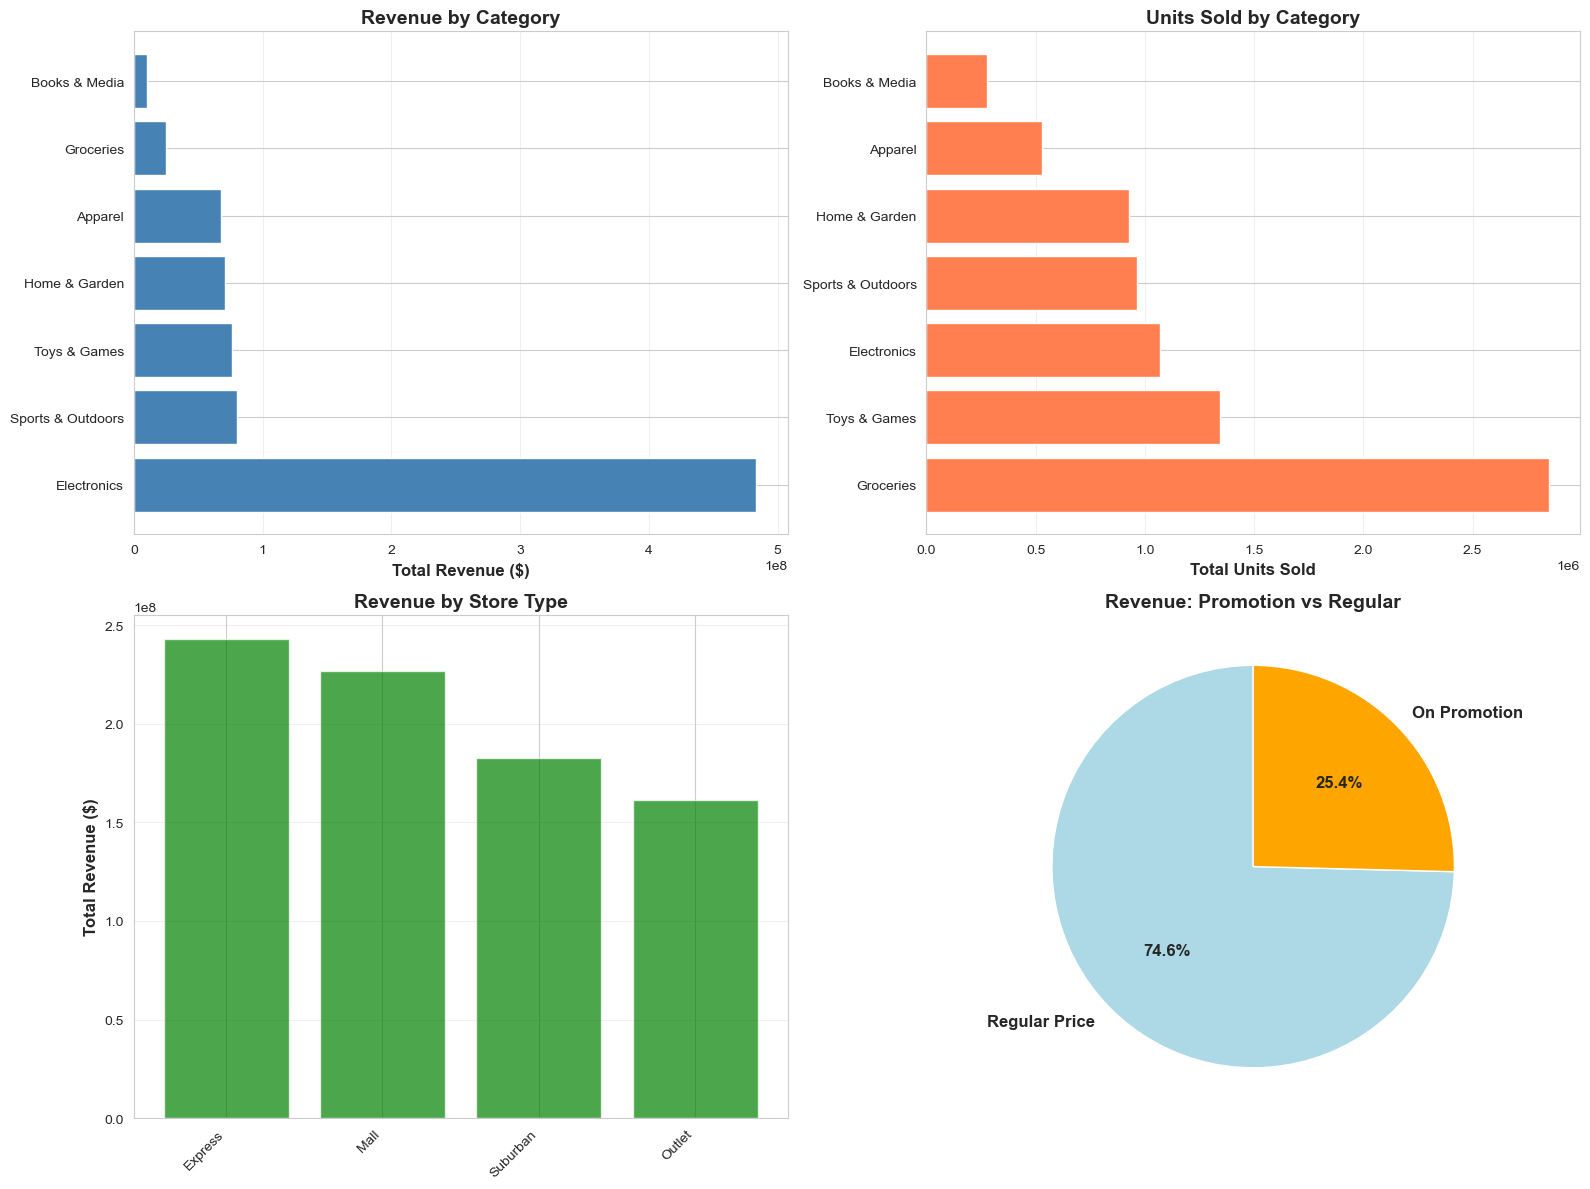

 Revenue analysis complete!


In [4]:
# %% Exploratory Data Analysis - Revenue Breakdown
# Visualize revenue and sales patterns across categories and stores

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Revenue by Category
category_revenue = sales_df.groupby('category')['revenue'].sum().sort_values(ascending=False)
axes[0, 0].barh(category_revenue.index, category_revenue.values, color='steelblue')
axes[0, 0].set_xlabel('Total Revenue ($)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Revenue by Category', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Units Sold by Category
category_units = sales_df.groupby('category')['units_sold'].sum().sort_values(ascending=False)
axes[0, 1].barh(category_units.index, category_units.values, color='coral')
axes[0, 1].set_xlabel('Total Units Sold', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Units Sold by Category', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Revenue by Store Type
store_revenue = sales_df.groupby('store_type')['revenue'].sum().sort_values(ascending=False)
axes[1, 0].bar(range(len(store_revenue)), store_revenue.values, color='green', alpha=0.7)
axes[1, 0].set_xticks(range(len(store_revenue)))
axes[1, 0].set_xticklabels(store_revenue.index, rotation=45, ha='right')
axes[1, 0].set_ylabel('Total Revenue ($)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Revenue by Store Type', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Promotion vs Regular Sales
promo_comparison = sales_df.groupby('promotion_active')['revenue'].sum()
labels = ['Regular Price', 'On Promotion']
colors = ['lightblue', 'orange']
axes[1, 1].pie(promo_comparison.values, labels=labels, colors=colors, 
               autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1, 1].set_title('Revenue: Promotion vs Regular', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(" Revenue analysis complete!")

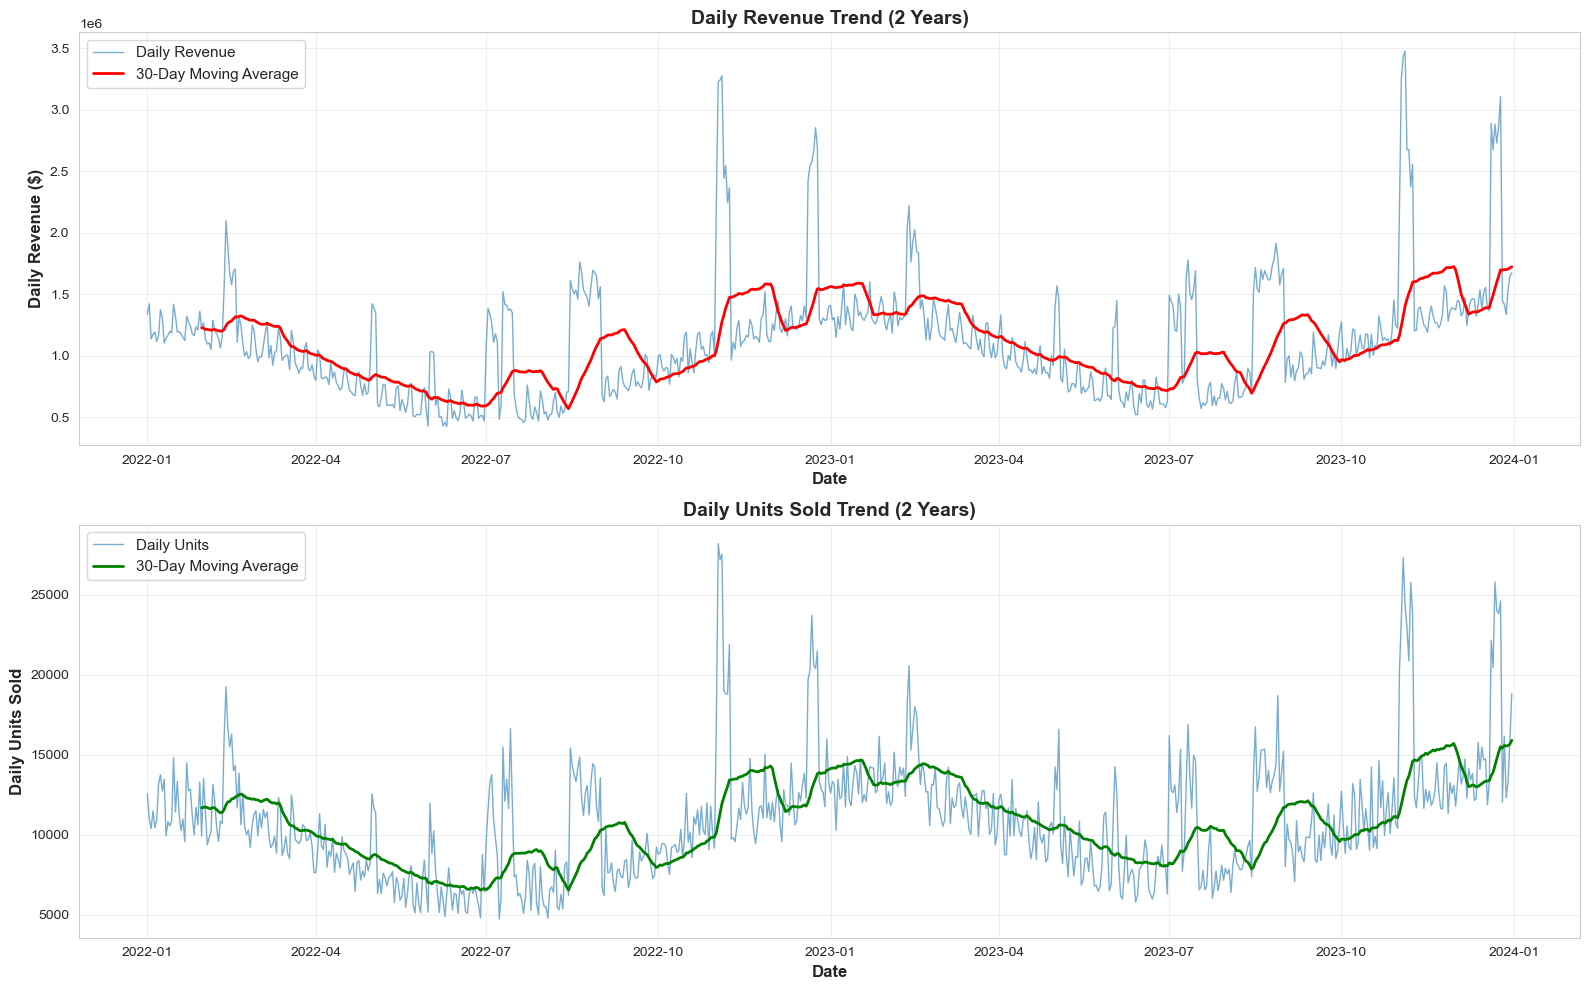

 Time series analysis complete!


In [5]:
# %% Time Series Analysis
# Analyze daily revenue and units sold trends over 2 years

daily_sales = sales_df.groupby('date').agg({
    'revenue': 'sum',
    'units_sold': 'sum'
}).reset_index()

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Daily revenue trend
axes[0].plot(daily_sales['date'], daily_sales['revenue'], 
             linewidth=1, alpha=0.6, label='Daily Revenue')
axes[0].plot(daily_sales['date'], daily_sales['revenue'].rolling(30).mean(), 
             color='red', linewidth=2, label='30-Day Moving Average')
axes[0].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Daily Revenue ($)', fontsize=12, fontweight='bold')
axes[0].set_title('Daily Revenue Trend (2 Years)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Units sold trend
axes[1].plot(daily_sales['date'], daily_sales['units_sold'], 
             linewidth=1, alpha=0.6, label='Daily Units')
axes[1].plot(daily_sales['date'], daily_sales['units_sold'].rolling(30).mean(), 
             color='green', linewidth=2, label='30-Day Moving Average')
axes[1].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Daily Units Sold', fontsize=12, fontweight='bold')
axes[1].set_title('Daily Units Sold Trend (2 Years)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(" Time series analysis complete!")

In [6]:
# %% Prepare Data for Forecasting Agent
# Aggregate sales data by SKU and date for model training

print(" Preparing data for forecasting agent...")

# Aggregate sales by date and SKU (across all stores)
sales_agg = sales_df.groupby(['date', 'sku_id', 'category']).agg({
    'units_sold': 'sum',
    'unit_price': 'mean',
    'cost': 'mean',
    'stockout': 'max'
}).reset_index()

# Rename for agent compatibility
sales_agg.rename(columns={'units_sold': 'sales', 'unit_price': 'price'}, inplace=True)

# Create external factors DataFrame
external_df = sales_df[['date', 'is_holiday', 'promotion_active']].drop_duplicates()
external_df = external_df.groupby('date').agg({
    'is_holiday': 'max',
    'promotion_active': 'mean'
}).reset_index()

print(f" Aggregated sales data: {len(sales_agg):,} records")
print(f" External factors: {len(external_df)} days")

display(sales_agg.head())

 Preparing data for forecasting agent...
 Aggregated sales data: 14,600 records
 External factors: 730 days


,date,sku_id,category,sales,price,cost,stockout
0,2022-01-01,SKU_0001,Books & Media,377,39.19,15.92,False
1,2022-01-01,SKU_0002,Sports & Outdoors,716,17.64,17.58,False
2,2022-01-01,SKU_0003,Sports & Outdoors,390,26.93,10.96,True
3,2022-01-01,SKU_0004,Toys & Games,605,22.54,10.99,False
4,2022-01-01,SKU_0005,Toys & Games,1090,45.95,33.79,False


In [7]:
# %% Initialize Forecasting Agent
# Create demand forecasting agent with ML capabilities

agent = DemandForecastingAgent()
print(" Demand Forecasting Agent initialized")
print("   - Gradient Boosting Regressor")
print("   - Feature engineering with lag and rolling statistics")
print("   - Continuous learning capabilities")

 Demand Forecasting Agent initialized
   - Gradient Boosting Regressor
   - Feature engineering with lag and rolling statistics
   - Continuous learning capabilities


In [8]:
# %% Train Forecasting Models
# Train ML models for first 5 SKUs (demo)

skus = sales_agg['sku_id'].unique()[:5]

print("🎓 Training forecasting models...\n")

for i, sku in enumerate(skus, 1):
    print(f"[{i}/{len(skus)}] Training model for {sku}...", end=" ")
    
    try:
        model, metrics = agent.train_model(sku, sales_agg, external_df)
        print(f" MAPE: {metrics['mape']:.2f}%, R²: {metrics['test_score']:.2%}")
    except Exception as e:
        print(f" Error: {e}")

print("\n Model training complete")

# Display model performance
performance_df = agent.get_model_performance()
print("\n Model Performance Summary:\n")
display(performance_df)

🎓 Training forecasting models...

[1/5] Training model for SKU_0001...  MAPE: 16.21%, R²: 63.27%
[2/5] Training model for SKU_0002...  MAPE: 18.83%, R²: 75.17%
[3/5] Training model for SKU_0003...  MAPE: 19.81%, R²: 71.75%
[4/5] Training model for SKU_0004...  MAPE: 24.35%, R²: 58.54%
[5/5] Training model for SKU_0005...  MAPE: 21.06%, R²: 61.42%

 Model training complete

 Model Performance Summary:



,train_score,test_score,mape
SKU_0001,0.977941,0.632696,16.207553
SKU_0002,0.991006,0.751711,18.830708
SKU_0003,0.988790,0.717470,19.809713
SKU_0004,0.973800,0.585363,24.351442
SKU_0005,0.981971,0.614181,21.059035


In [9]:
# %% Generate 30-Day Forecast
# Generate demand forecast for next 30 days with confidence intervals

# Select a SKU for detailed analysis
sku = skus[0]
print(f" Generating 30-day forecast for {sku}...")

# Get product info
sku_info = sales_df[sales_df['sku_id'] == sku].iloc[0]
print(f"   Product: {sku_info['product_name']}")
print(f"   Category: {sku_info['category']}")
print(f"   Brand: {sku_info['brand']}")

# Generate forecast
future_dates = pd.date_range(start=pd.Timestamp.now(), periods=30, freq='D')
forecast_df = agent.predict_demand(sku, future_dates, external_df)

print(f"\n Forecast generated")
print(f"   Avg predicted demand: {forecast_df['predicted_demand'].mean():.1f} units/day")
print(f"   Peak demand: {forecast_df['predicted_demand'].max()} units")
print(f"   Total 30-day demand: {forecast_df['predicted_demand'].sum():,} units")

display(forecast_df.head(10))

 Generating 30-day forecast for SKU_0001...
   Product: Cookbook 1
   Category: Books & Media
   Brand: MediaHub

 Forecast generated
   Avg predicted demand: 207.7 units/day
   Peak demand: 239 units
   Total 30-day demand: 6,232 units


,date,sku_id,predicted_demand,lower_bound,upper_bound,confidence
0,2025-11-24 08:52:36.140257,SKU_0001,199,135,262,95
1,2025-11-25 08:52:36.140257,SKU_0001,196,134,259,95
2,2025-11-26 08:52:36.140257,SKU_0001,200,137,264,95
3,2025-11-27 08:52:36.140257,SKU_0001,201,137,266,95
4,2025-11-28 08:52:36.140257,SKU_0001,201,137,266,95
5,2025-11-29 08:52:36.140257,SKU_0001,205,140,270,95
6,2025-11-30 08:52:36.140257,SKU_0001,202,137,266,95
7,2025-12-01 08:52:36.140257,SKU_0001,223,152,294,95
8,2025-12-02 08:52:36.140257,SKU_0001,209,143,276,95
9,2025-12-03 08:52:36.140257,SKU_0001,207,141,273,95


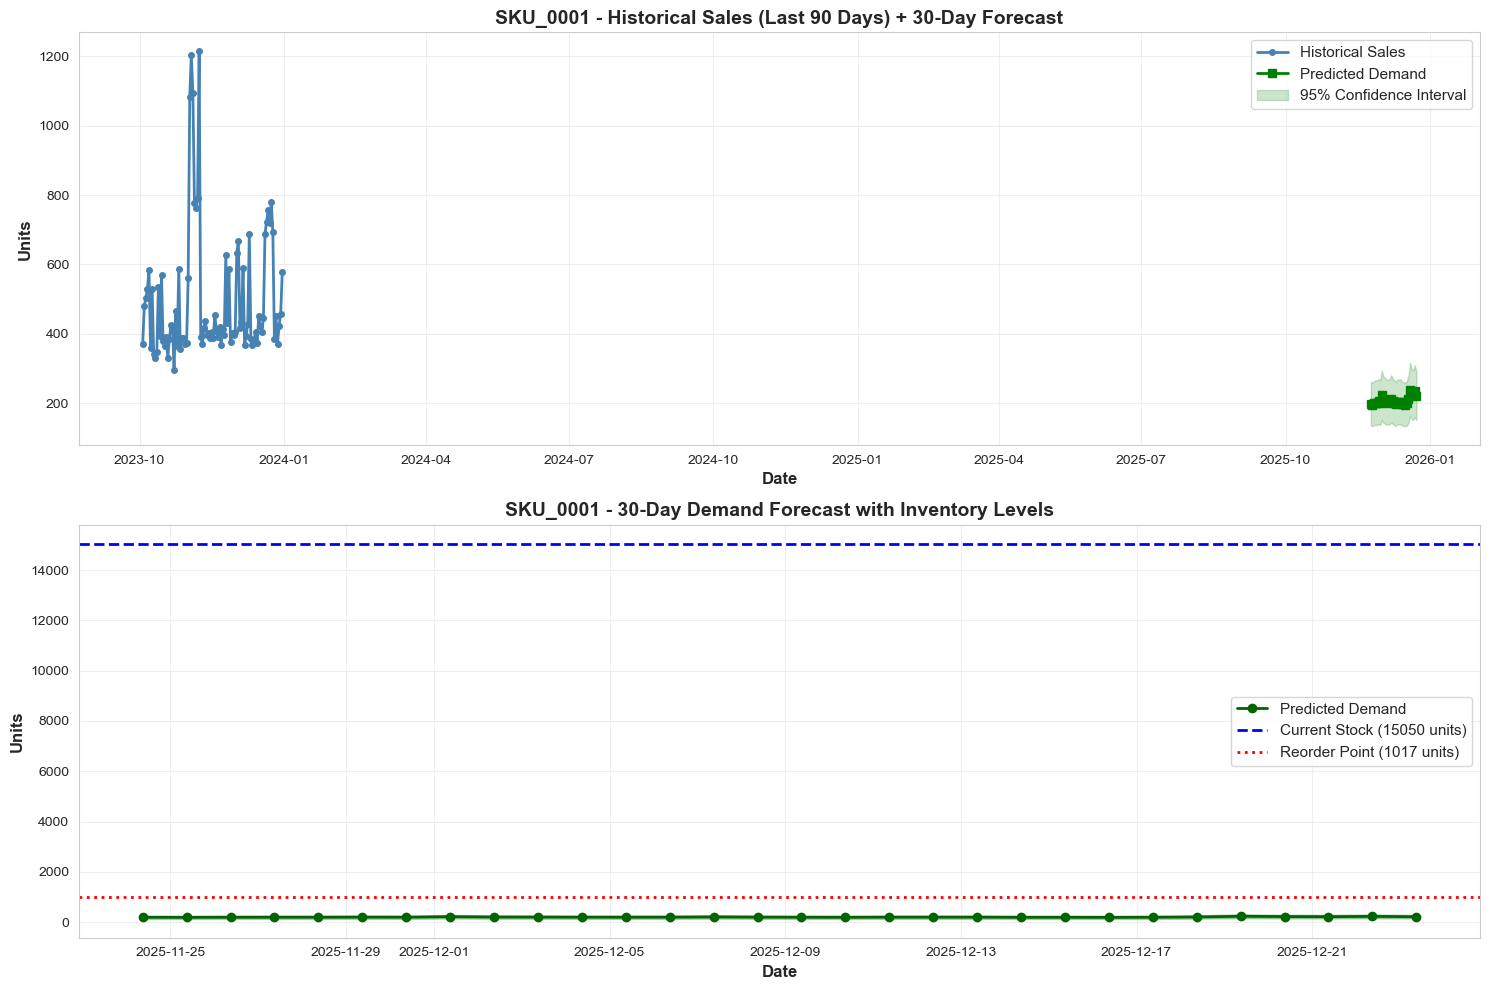

 Forecast visualization complete!


In [10]:
# %% Visualize Forecast
# Plot historical sales + 30-day forecast with confidence intervals

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Historical + Forecast
sku_history = sales_agg[sales_agg['sku_id'] == sku].tail(90)
ax1.plot(sku_history['date'], sku_history['sales'], 'o-', linewidth=2, 
         label='Historical Sales', color='steelblue', markersize=4)
ax1.plot(forecast_df['date'], forecast_df['predicted_demand'], 's-', linewidth=2,
         label='Predicted Demand', color='green', markersize=6)
ax1.fill_between(forecast_df['date'], 
                  forecast_df['lower_bound'], 
                  forecast_df['upper_bound'],
                  alpha=0.2, color='green', label='95% Confidence Interval')
ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_ylabel('Units', fontsize=12, fontweight='bold')
ax1.set_title(f'{sku} - Historical Sales (Last 90 Days) + 30-Day Forecast', 
              fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# Forecast detail with inventory levels
ax2.plot(forecast_df['date'], forecast_df['predicted_demand'], 'o-', linewidth=2,
         label='Predicted Demand', color='darkgreen', markersize=6)
ax2.fill_between(forecast_df['date'], 
                  forecast_df['lower_bound'], 
                  forecast_df['upper_bound'],
                  alpha=0.3, color='green')

# Add inventory levels
inv_info = inventory_df[inventory_df['sku_id'] == sku]
if len(inv_info) > 0:
    current_stock = inv_info['current_stock'].sum()
    reorder_point = inv_info['reorder_point'].mean()
    
    ax2.axhline(y=current_stock, color='blue', linestyle='--', linewidth=2,
                label=f'Current Stock ({int(current_stock)} units)')
    ax2.axhline(y=reorder_point, color='red', linestyle=':', linewidth=2,
                label=f'Reorder Point ({int(reorder_point)} units)')

ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.set_ylabel('Units', fontsize=12, fontweight='bold')
ax2.set_title(f'{sku} - 30-Day Demand Forecast with Inventory Levels', 
              fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(" Forecast visualization complete!")

In [11]:
# %% Calculate Dynamic Reorder Recommendation
# Calculate optimal reorder point and quantity based on forecast

# Get inventory info
inv_info = inventory_df[inventory_df['sku_id'] == sku]

if len(inv_info) > 0:
    total_stock = inv_info['current_stock'].sum()
    avg_lead_time = int(inv_info['lead_time_days'].mean())
    
    reorder_info = agent.calculate_dynamic_reorder(
        sku,
        forecast_df,
        total_stock,
        avg_lead_time
    )
    
    # Display recommendation
    print("\n" + "="*70)
    print(f" REORDER RECOMMENDATION - {sku}")
    print(f"    {sku_info['product_name']} ({sku_info['category']})")
    print("="*70)
    
    print(f"\n CURRENT STATUS:")
    print(f"   Total Stock Across Stores: {reorder_info['current_stock']:,} units")
    print(f"   Reorder Point: {reorder_info['reorder_point']:,} units")
    print(f"   Safety Stock: {reorder_info['safety_stock']:,} units")
    print(f"   Lead Time: {avg_lead_time} days")
    
    print(f"\n FORECAST INSIGHTS:")
    print(f"   Expected Demand (Lead Time): {reorder_info['lead_time_demand']:,} units")
    print(f"   Days Until Stockout: {reorder_info['days_until_stockout']} days")
    print(f"   Avg Daily Demand (Forecast): {forecast_df['predicted_demand'].mean():.1f} units")
    
    print(f"\n RECOMMENDATION:")
    print(f"   Urgency Level: {reorder_info['urgency']}")
    print(f"   Reorder Needed: {'YES ⚠️' if reorder_info['needs_reorder'] else 'NO ✓'}")
    print(f"   Recommended Order Quantity: {reorder_info['reorder_quantity']:,} units")
    
    if reorder_info['needs_reorder']:
        print(f"   ⚡ ACTION REQUIRED: Place order immediately!")
    
    print("\n" + "="*70)
else:
    print(f" No inventory data available for {sku}")


 REORDER RECOMMENDATION - SKU_0001
    Cookbook 1 (Books & Media)

 CURRENT STATUS:
   Total Stock Across Stores: 15,050 units
   Reorder Point: 1,644 units
   Safety Stock: 17 units
   Lead Time: 8 days

 FORECAST INSIGHTS:
   Expected Demand (Lead Time): 1,627 units
   Days Until Stockout: 30 days
   Avg Daily Demand (Forecast): 207.7 units

 RECOMMENDATION:
   Urgency Level: LOW
   Reorder Needed: NO ✓
   Recommended Order Quantity: 3,323 units



In [12]:
# %% Optional: AI-Powered Analysis with Qwen2.5
# OPTIONAL: Generate AI insights using Qwen2.5 model
# Skip this cell if you don't have a local model or want to avoid downloading
#
# Options:
# 1. Use local model at http://127.0.0.1:8080
# 2. Download Qwen2.5-7B (requires ~5GB download)

# Uncomment to use LOCAL model
model_loader = ModelLoader(
    model_name='qwen2.5-7b',
    use_local=True,
    local_endpoint='http://127.0.0.1:8080'
)
model_loader.load_model()

# Uncomment to DOWNLOAD model (requires ~5GB, takes 10+ minutes)
# model_loader = ModelLoader(model_name='qwen2.5-7b', device='cpu')
# model_loader.load_model()

# Prepare analysis data
historical_data = {
    'avg_sales': sku_history['sales'].mean(),
    'trend': 'increasing' if sku_history['sales'].iloc[-1] > sku_history['sales'].iloc[0] else 'decreasing',
    'seasonality': 'moderate',
    'stockout_rate': 1.5,
    'current_stock': reorder_info['current_stock'],
    'reorder_point': reorder_info['reorder_point'],
    'lead_time': avg_lead_time
}

forecast_data = {
    'predicted_avg': forecast_df['predicted_demand'].mean(),
    'peak_demand': forecast_df['predicted_demand'].max(),
    'peak_day': forecast_df['predicted_demand'].idxmax() + 1,
    'confidence': 95
}

external_factors = {
    'economic_index': 102,
    'seasonal': 'winter',
    'promotion': 'active' if sales_df['promotion_active'].sum() > 0 else 'none'
}

# Generate AI analysis
print("Generating AI-powered analysis...\n")
analysis = model_loader.analyze_forecast(
    historical_data,
    forecast_data,
    external_factors
)

print("="*70)
print(" AI ANALYSIS")
print("="*70)
print(analysis)
print("="*70)

print("\n AI analysis complete!")

 Using local model at http://127.0.0.1:8080
  No model download required - using local inference server
 Local model server is responsive
Generating AI-powered analysis...

 AI ANALYSIS
.

. Risk Assessment:

Stockout Risk: The current stockout rate is 1.5%, which indicates a relatively low risk of stockouts. However, with the predicted peak demand of 239 units on Day 26, there is a possibility of a stockout if the inventory is not replenished in time.

Overstock Risk: The predicted average daily sales of 207.73 units are lower than the historical average daily sales of 495.74 units, indicating a potential risk of overstocking. With the current stock of 15050 units and a reorder point of 1644 units, there is a significant amount of inventory on hand.

3. Recommended Actions:

Reorder Quantity: Given the predicted peak demand of 239 units on Day 26, the reorder quantity should be around 250 units to ensure adequate stock for the peak demand period and to avoid stockouts.

Reorder Timing

In [13]:
# %% Launch Interactive Dashboard
# Launch web-based dashboard for interactive analysis

# Prepare inventory summary for dashboard
inv_summary = inventory_df.groupby('sku_id').agg({
    'current_stock': 'sum',
    'reorder_point': 'mean',
    'reorder_quantity': 'mean',
    'lead_time_days': 'mean',
    'unit_cost': 'first',
    'unit_price': 'first',
    'category': 'first'
}).reset_index()

print(" Launching Interactive Dashboard...")
print("\n" + "="*70)
print("DASHBOARD INFORMATION")
print("="*70)
print("\n URL: http://127.0.0.1:8050")
print("\n Features:")
print("   • Select any SKU from dropdown")
print("   • Adjust forecast horizon (7-90 days)")
print("   • View historical sales patterns")
print("   • See reorder recommendations")
print("   • Check model performance metrics")
print("\n  Note: Dashboard runs in blocking mode")
print("   Press Ctrl+C in terminal to stop")
print("="*70 + "\n")

# Create and launch dashboard
dashboard = ForecastingDashboard(agent, sales_agg, external_df, inv_summary)
dashboard.run(host='127.0.0.1', port=8050, debug=True)

 Launching Interactive Dashboard...

DASHBOARD INFORMATION

 URL: http://127.0.0.1:8050

 Features:
   • Select any SKU from dropdown
   • Adjust forecast horizon (7-90 days)
   • View historical sales patterns
   • See reorder recommendations
   • Check model performance metrics

  Note: Dashboard runs in blocking mode
   Press Ctrl+C in terminal to stop


🚀 LAUNCHING AI DEMAND FORECASTING DASHBOARD

📊 Dashboard URL: http://127.0.0.1:8050

✨ Features:
   • Comprehensive demand forecasting with ML
   • Dynamic reorder recommendations
   • Historical trend analysis
   • Seasonality and weekly patterns
   • Risk assessment dashboard
   • AI-powered insights
   • Real-time interactive visualizations

⚠️  Press Ctrl+C to stop the server



In [14]:
# %% Save Results
# Save all generated data and results to CSV files

print(" Saving data to files...")

sales_df.to_csv('../data/retail_sales_full.csv', index=False)
inventory_df.to_csv('../data/retail_inventory.csv', index=False)

print("\n Files saved:")
print("   • data/retail_sales_full.csv")
print("   • data/retail_inventory.csv")

print("\n Analysis complete!")

 Saving data to files...

 Files saved:
   • data/retail_sales_full.csv
   • data/retail_inventory.csv

 Analysis complete!
